<a href="https://colab.research.google.com/github/shumshersubashgautam/Quantum-MNIST-Classification/blob/main/Quantum_Helloworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.7.0
from IPython.display import clear_output
clear_output()
     

In [2]:
!pip install tensorflow-quantum==0.7.2
from IPython.display import clear_output
clear_output()
     

In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py'>

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [5]:
a, b = sympy.symbols('a b')

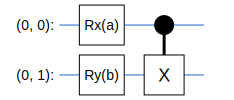

In [6]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

In [7]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [8]:
z0 = cirq.Z(q0)

qubit_map={q0: 0, q1: 1}

z0.expectation_from_state_vector(output_state_vector, qubit_map).real

0.8775825500488281

In [9]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real

-0.04063427448272705

In [10]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [11]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [12]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [13]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, {
            q0: 0,
            q1: 1
        }).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.51826435]
 [-0.97770411]
 [-0.13550496]
 [ 0.26132882]
 [ 0.88978595]]


In [14]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.5182661 ],
       [-0.9777043 ],
       [-0.13550553],
       [ 0.26133025],
       [ 0.8897867 ]], dtype=float32)>

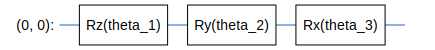

In [15]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [16]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [17]:
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.15105487,  0.18319066,  0.23665074]], dtype=float32)

In [18]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [19]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [20]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

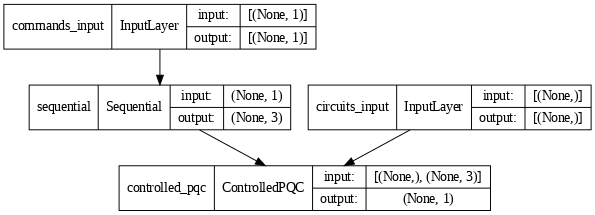

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [22]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [23]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [24]:
datapoint_circuits.shape

TensorShape([2])

In [25]:
model([datapoint_circuits, commands]).numpy()

array([[ 0.20155263],
       [-0.05527088]], dtype=float32)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

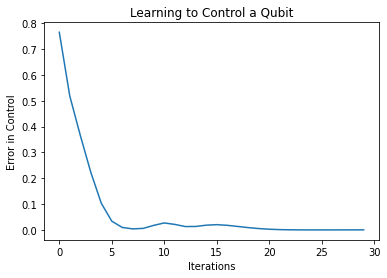

In [27]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [28]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 0.35703316 -1.3475282  -0.02824658]
Which gives an actual expectation of: 0.9896680116653442

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-1.5555962  1.4369333  1.6759653]
Which gives an actual expectation of: -0.9750663638114929



In [29]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.98966837],
       [-0.9750664 ]], dtype=float32)>

In [30]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [31]:
# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [32]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [33]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 1.1497
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 0.5087
Epoch 3/30
1/1 [==============================] - 0s 12ms/step - loss: 0.1833
Epoch 4/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0657
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0362
Epoch 6/30
1/1 [==============================] - 0s 10ms/step - loss: 0.0338
Epoch 7/30
1/1 [==============================] - 0s 14ms/step - loss: 0.0423
Epoch 8/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0555
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 0.0630
Epoch 10/30
1/1 [==============================] - 0s 10ms/step - loss: 0.0573
Epoch 11/30
1/1 [==============================] - 0s 12ms/step - loss: 0.0426
Epoch 12/30
1/1 [==============================] - 0s 12ms/step - loss: 0.0270
Epoch 13/30
1/1 [==============================] - 0s 11ms/step - l

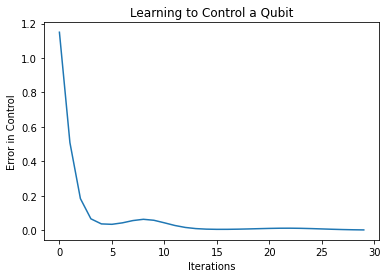

In [35]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [36]:
controller.predict(np.array([0,1]))

array([[ 0.14228225,  0.04653189,  0.599291  ],
       [-0.08537924,  1.6241204 ,  0.5407978 ]], dtype=float32)